In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/chat-slang-abbreviations-acronyms/slang/slang.pkl
/kaggle/input/chat-slang-abbreviations-acronyms/slang/slang.csv
/kaggle/input/chat-slang-abbreviations-acronyms/slang/slang.txt
/kaggle/input/chat-slang-abbreviations-acronyms/slang/slang.json
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv


In [2]:
# Importing important libraries 
import numpy as np
import pandas as pd
import os
import sys
import csv
import glob
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import models
import torch.utils.data as data
from torch.utils.data import Dataset,DataLoader

# Importing PyTorch Lightning modules

import pytorch_lightning as pl
from pytorch_lightning.core import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer, seed_everything
from pathlib import Path
from typing import Optional
import torchmetrics
from torchmetrics import Metric
import torchvision
import warnings


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import re
import nltk 
import string
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
pl.seed_everything(42)

42

In [4]:
# Importing AutoModelForQuestionAnswering,autokenizer for loading tinyroberta pre-trained model
from transformers import AutoModelForQuestionAnswering, AutoTokenizer,DistilBertForQuestionAnswering

In [5]:
# Wandb will be used to save logs and plots
!pip install wandb

In [6]:
import os
print(os.cpu_count())
os.environ["TOKENIZERS_PARALLELISM"] = "false"

2


In [7]:
import sys
sys.path.append('/kaggle/input')
# load the data to a pandas dataframe
train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test  = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

# Pre-Process Data

In [8]:
# This function finds index of first letter of first token to be used 
# for finding index of token in original text , using tokenizer of tinyroberta model  
def find_start_indicesLET(x):
    text, sel_text = x[0], x[1]
    index = text.find(sel_text)
    if index != -1:
        return index
    else:
        return 0

In [9]:
# This function finds index of last letter of last token to be used 
# for finding index of token in original text , using tokenizer of tiny roberta model  
def find_end_indicesLET(x):
    text, sel_text, start_indices = x[0], x[1], x[2]
    start_index = start_indices + len(sel_text) - 1
    index = text.find(sel_text, start_indices)
    if index != -1:
        return start_index
    else:
        return start_index + 1

In [10]:
def spacing_punctuation(text):
    # Add spaces before and after punctuations
    regular_punct = list(string.punctuation)
    for punc in regular_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text.strip()

In [11]:
def clear_text(text):
  text = re.sub(r'(\w)\1{2,}', r'\1\1', text) #Removing repeated letters(more than 2 times) ex:(sooooooooo) -> (soo)
  text = re.sub('`',"'",text)                 #Replacing apostrophe
  text = re.sub('\S*\d\S*',' ',text)          #Removing Numbers
  text = re.sub('<.*?>+',' ',text)            #Removing Angular Brackets
  text = re.sub('\[.*?\]',' ',text)           #Removing Square Brackets
  text = re.sub('\n',' ',text)                #Removing '\n' character 
  return text

In [12]:
def remove_hyperlinks(text):
  hyperlinkfree = re.sub('https?://\S+|www\.\S+', '', text)
  return hyperlinkfree

In [13]:
# Dropping Nulls
train.dropna(inplace=True)
train.dropna(inplace=True)

# Applying all preprocessing functions
train['text'] = train['text'].apply(remove_hyperlinks)
train['text'] = train['text'].apply(clear_text)
train['selected_text'] = train['selected_text'].apply(remove_hyperlinks)
train['selected_text'] = train['selected_text'].apply(clear_text)
train['text'] = train['text'].apply(spacing_punctuation)
train['selected_text'] = train['selected_text'].apply(spacing_punctuation)

In [14]:
train['start_indices_LET'] = train[['text','selected_text']].apply(lambda x:find_start_indicesLET(x),axis=1)
train['end_indices_LET'] = train[['text','selected_text','start_indices_LET']].apply(lambda x:find_end_indicesLET(x),axis=1)

In [15]:
train

,textID,text,selected_text,sentiment,start_indices_LET,end_indices_LET
0,cb774db0d1,"I ' d have responded , if I were going","I ' d have responded , if I were going",neutral,0,38
1,549e992a42,Soo SAD I will miss you here in San Diego ! ! !,Soo SAD,negative,0,6
2,088c60f138,my boss is bullying me . . .,bullying me,negative,11,21
3,9642c003ef,what interview ! leave me alone,leave me alone,negative,18,31
4,358bd9e861,"Sons of * * * * , why couldn ' t they pu...","Sons of * * * * ,",negative,0,21
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lo...,d lost,negative,42,47
27477,4f4c4fc327,I ' ve wondered about rake to . The client h...,", don ' t force",negative,75,90
27478,f67aae2310,Yay good for both of you . Enjoy the break -...,Yay good for both of you .,positive,0,25
27479,ed167662a5,But it was worth it * * * * .,But it was worth it * * * * .,positive,0,34


In [16]:
train , test = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)
train , val = train_test_split(train, test_size=0.05, random_state=42, shuffle=True)

In [17]:
val

,textID,text,selected_text,sentiment,start_indices_LET,end_indices_LET
9709,2ab31350aa,has uploaded her runs onto NikePlus . com . ...,has uploaded her runs onto NikePlus . com . ...,neutral,0,87
14312,3b18761a3a,just got home from church . The Service was good,The Service was good,positive,29,48
13911,0abb903755,I was awake until then my mum turned the int...,sad,negative,110,112
25026,05a1304b53,Where ' s my bus ? I want to go home !,Where ' s my bus ? I want to go home !,neutral,0,38
17170,d9ec842df1,i can ' t listen to music at work I probably ...,can ' t listen,negative,2,15
...,...,...,...,...,...,...
20222,61a156b603,I can ' t die I have a lunch date with rocio ...,s UGH,negative,74,78
9544,b5a5f20261,Hate be late,Hate,negative,0,3
8563,d05cc52d1a,It ' s cold and cloudy and I have a million lo...,It ' s cold and cloudy and I have a million lo...,neutral,0,65
13730,c4db64f19d,i dont get it,i dont get it,neutral,0,12


# Fine Tunning

In [18]:
MODEL_NAME = "deepset/tinyroberta-squad2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

In [19]:
train.iloc[100]

textID                                                      02c61e2c17
text                 sometimes i wish things could go back to the w...
selected_text        sometimes i wish things could go back to the w...
sentiment                                                      neutral
start_indices_LET                                                    0
end_indices_LET                                                     86
Name: 16613, dtype: object

In [20]:
class TweetExtractionData(torch.utils.data.Dataset):
# Tweet Extraction Data is our custom dataset    
    def __init__(self,
                 data: pd.DataFrame,
                 tokenizer: AutoTokenizer,
                 source_max_token_len: int = 40):
    # init itializes tokenizer and dataset             
            self.tokenizer  = tokenizer
            self.data = data
            self.source_max_token_len = source_max_token_len
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        #Tokenizer takes the sentiment as a question and text as inputs
        input_enc = tokenizer(
            row["sentiment"] ,
            row["text"],
            max_length=self.source_max_token_len, 
            padding="max_length", 
            truncation="only_second",
            return_offsets_mapping=True,
            return_attention_mask = True,
            add_special_tokens = True,
            return_tensors = "pt"
            )
        
        offset_mapping  = input_enc["offset_mapping"]
        # Offset mappings ,returned from tokenizer,
        # provides the starting position of each token 
        start_position  = 0
        end_position    = 0

        start_char      = row["start_indices_LET"]
        end_char        = row["end_indices_LET"]
        sequence_ids    = input_enc.sequence_ids(0)

            # Find the start and end of the text
            # sequence_ids will be 0 for question or sentiment
            # and 1 for text
        idx = 0
        while idx < len(sequence_ids) and sequence_ids[idx] != 1:
                idx += 1
        # start of Text  
        context_start = idx
        while idx < len(sequence_ids) and sequence_ids[idx] == 1:
                idx += 1
        context_end = idx - 1 #end of text index

        
        # We used index of first letter of first token calculated in preprocessing step
        # to determine index of first token(this will be our ground truth start index)
        idx = context_start
        while idx <= context_end and offset_mapping[0,idx,0] <= start_char:
            idx += 1
        start_position = idx - 1

        # We used index of last letter of last token calculated in preprocessing step
        # to determine index of last token(this will be our ground truth end index)
        # Note that token index is calculated using offset mappings to be consisted with this model tokenizer
        idx = context_end
        while idx >= context_start and offset_mapping[0,idx,1] >= end_char:
            idx -= 1
        end_position = idx + 1
        
        #Getitem function returns a dictionary that contains sentiment,text,answer,
        #start and end positions(ground truth),input ids,attention masks
        return dict(
            sentiment = row["sentiment"] ,
            text = row["text"], 
            answer = row["selected_text"],
            st   = start_position,
            end  = end_position,
            input_ids = input_enc["input_ids"].flatten(), 
            attention_mask =input_enc["attention_mask"].flatten()
            )

In [21]:
class DataModuleClass(pl.LightningDataModule):
    #Data Module Class takes train,test,val sets and batch sizes as inputs
    def __init__(self,
                 train_data: pd.DataFrame,
                 val_data: pd.DataFrame,
                 test_data: pd.DataFrame,
                 tokenizer: AutoTokenizer,
                 batch_size_train: int =  128,
                 batch_size_val: int =  64,
                 source_max_token_len: int = 40):
        super().__init__()
        self.batch_size_train = batch_size_train
        self.batch_size_val   = batch_size_val
        self.train_data       = train_data
        self.val_data = val_data
        self.test_data  = test_data
        self.tokenizer  = AutoTokenizer
        self.source_max_token_len=source_max_token_len
    
    # Setup function prepares train,validation ,prediction(test) data loaders ,they will then be used for training
    def setup(self, stage=None):
        self.train_dataset = TweetExtractionData(
            self.train_data ,
            self.tokenizer ,
            self.source_max_token_len,
            )
        self.predict_dataset = TweetExtractionData(
            self.test_data,
            self.tokenizer  ,
            self.source_max_token_len,
            ) 
        self.val_dataset = TweetExtractionData(
            self.val_data,
            self.tokenizer  ,
            self.source_max_token_len,
            ) 
    def train_dataloader(self):
        return DataLoader(
        self.train_dataset,
        batch_size =self.batch_size_train,
        shuffle =True,
        # Specify the number of worker processes to use for loading the data in parallel.
        num_workers=2
        )
    
    def val_dataloader(self):
        return DataLoader(
        self.val_dataset,
        batch_size =self.batch_size_val,
        # Specify the number of worker processes to use for loading the data in parallel.    
        num_workers=2    
        )
    def predict_dataloader(self):
        return DataLoader(
        self.predict_dataset,
        batch_size =self.batch_size_val,
        # Specify the number of worker processes to use for loading the data in parallel.
        num_workers=2  
        )
    

In [22]:
BATCH_SIZE_train  = 128
BATCH_SIZE_val    = 64
N_EPOCHS          = 100
data_module = DataModuleClass(train, val, test, tokenizer, batch_size_train = BATCH_SIZE_train,batch_size_val = BATCH_SIZE_val )
data_module.setup()

In [23]:
data_module

In [24]:
for batch in data_module.train_dataloader():
    print(len(batch))
    print(batch["input_ids"].shape,batch["attention_mask"].shape)
    break

7
torch.Size([128, 40]) torch.Size([128, 40])


In [25]:
def jaccard(str1, str2): 
    doc1 = set(str1.lower().split()) 
    doc2 = set(str2.lower().split())
    if (len(doc1)==0) & (len(doc2)==0): return 0.5
    c = doc1.intersection(doc2)
    return float(len(c)) / (len(doc1) + len(doc2) - len(c))

In [26]:
class MyJaccard(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("correct", default=torch.tensor(0), dist_reduce_fx="sum")
    def update(self, preds, ans):
        c = set()
        self.correct = self.correct.float()
        #iterating over predicted text and original selected text
        for i,t in enumerate(zip(preds,ans)):
               pred = t[0]
               str2  = t[1] 
               #Convert the input strings to lowercase using the lower() method to ensure case insensitivity.
               doc1 = set(pred.lower().split()) 
               doc2 = set(str2.lower().split())
               #Check if both doc1 and doc2 are empty sets (len(doc1)==0 and len(doc2)==0). 
            #If they are both empty, it means there are no words in either string, and the Jaccard similarity coefficient is set to 0.5 (a default value indicating a neutral similarity).
               if (len(doc1)==0) & (len(doc2)==0): 
                    self.correct += 0.5
                    continue
               #If the sets are not empty, calculate the intersection of doc1 and doc2 using the intersection() method.
               c = doc1.intersection(doc2)
               # Calculate the Jaccard similarity coefficient by dividing the size of the intersection (len(c)) by the size of the union of doc1 and doc2 
               self.correct += len(c)*1.0 / (len(doc1) + len(doc2) - len(c))
        
        # total is total number of element
        self.total += len(preds)

    def compute(self):
        #We divide all jaccard scores by their number to calculate jaccard((alljaccards).mean())
        return self.correct.float() / self.total.float()

In [27]:

class TweetModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        #Initialize AutoModelForQuestionAnswering pretrained model(tinyroberta)
        self.model                 = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
        self.tokenizer             = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.my_jaccard_train      = MyJaccard()
        self.my_jaccard_val        = MyJaccard()
        self.my_jaccard_test       = MyJaccard()
        self.outputs               = []
        self.train_loss            = 0.0
        self.train_jaccard         = 0.0
        self.val_loss              = 0.0
        self.val_jaccard           = 0.0
    
    def forward(self, input_ids, attention_mask, start_positions =None ,end_positions =None , return_loss=True):
        output = self.model (
                            input_ids       = input_ids, 
                            attention_mask  = attention_mask,
                            #Start and End positions(gd truth) to calculate loss
                            start_positions = start_positions,
                            end_positions   = end_positions    
                            )
        return output.loss,output.start_logits,output.end_logits 
    
    def training_step(self, batch, batch_idx):
        input_ids               = batch["input_ids"]
        attention_mask          = batch["attention_mask"]
        start_positions         = batch["st"]
        end_positions           = batch["end" ]
        ans                     = batch["answer"]
        text                    = batch["text"]
        # Output1 and output2 represent start & end logits
        loss, output1,output2   = self(input_ids, attention_mask, start_positions ,end_positions )
        # Index of max output1 or 2 represent index of start and end tokens
        out1                    = torch.argmax(output1, dim=1).detach().cpu()
        out2                    = torch.argmax(output2, dim=1).detach().cpu()
        preds                   = []
        regular_punct           = list(string.punctuation)

        
        for i in range(input_ids.shape[0]):
            # if start index is less than end index decode predicted sentence
            if (out1[i] <= out2[i]):
                input_id = input_ids[i][out1[i] : out2[i]+1]
                sentence = tokenizer.decode(input_id, skip_special_tokens=True)
            # if start index is greater than end index sentence will be original text   
            else:
                sentence = text[i]
            #We put space before&after punctuation to correctly compare tokens when calculating jaccard  
            for punc in regular_punct:
                if punc in sentence:
                    sentence = sentence.replace(punc, f' {punc} ')
            sentence = sentence.strip()
            preds.append(sentence)

        jaccard               = self.my_jaccard_train(preds,ans)
        self.train_loss       = loss
        self.train_jaccard    = jaccard
        self.log("train_loss", loss, prog_bar=True, logger=True) 
        self.log("train_jaccard", jaccard, prog_bar=True, logger=True) 
        return {"loss":loss}
    
    def test_step(self, batch, batch_idx):
        input_ids               = batch["input_ids"]
        attention_mask          = batch["attention_mask"]
        start_positions         = batch["st"]
        end_positions           = batch["end" ]
        ans                     = batch["answer"]
        text                    = batch["text"]
        # Output1 and output2 represent start & end logits
        loss, output1,output2   = self(input_ids, attention_mask, start_positions ,end_positions )
        # Index of max output1 or 2 represent index of start and end tokens
        out1                    = torch.argmax(output1, dim=1).detach().cpu()
        out2                    = torch.argmax(output2, dim=1).detach().cpu()
        preds                   = []
        for i in range(input_ids.shape[0]):
            
            # if start index is less than end index decode predicted sentence
            if (out1[i] <= out2[i]):
                input_id = input_ids[i][out1[i] : out2[i]+1]
                sentence = tokenizer.decode(input_id, skip_special_tokens=True)
            
            # if start index is greater than end index sentence will be original text       
            else:
                sentence = text[i]
            
            #Here we put space before&after punctuation to correctly compare tokens when calculating jaccard  
            for punc in regular_punct:
                if punc in sentence:
                    sentence = sentence.replace(punc, f' {punc} ')
            sentence = sentence.strip()
            preds.append(sentence)
        jaccard             = self.my_jaccard_test(preds,ans)
        self.log("test_loss", loss, prog_bar=True, logger=True) 
        self.log("test_jaccard", jaccard, prog_bar=True, logger=True) 
        return {"loss":loss}

    
    def predict_step(self, batch, batch_idx):
        input_ids               = batch["input_ids"]
        attention_mask          = batch["attention_mask"]
        start_positions         = batch["st"]
        end_positions           = batch["end" ]
        ans                     = batch["answer"]
        text                    = batch["text"]
        # Output1 and output2 represent start & end logits
        loss, output1,output2   = self(input_ids, attention_mask, start_positions ,end_positions )
        # Index of max output1 or 2 represent index of start and end tokens
        out1                    = torch.argmax(output1, dim=1).detach().cpu()
        out2                    = torch.argmax(output2, dim=1).detach().cpu()
        preds                   = []
        regular_punct           = list(string.punctuation)

        for i in range(input_ids.shape[0]):
            if (out1[i] <= out2[i]):
                input_id = input_ids[i][out1[i] : out2[i]+1]
                sentence = tokenizer.decode(input_id, skip_special_tokens=True)
                
            else:
                sentence = text[i]
            #We put space before&after punctuation to correctly compare tokens when calculating jaccard  
            for punc in regular_punct:
                if punc in sentence:
                    sentence = sentence.replace(punc, f' {punc} ')
            sentence = sentence.strip()
            preds.append(sentence)
        
        jaccard             = self.my_jaccard_test(preds,ans)        
        #Return predictions of test set
        return preds,jaccard
    
    def validation_step(self, batch, batch_idx):
        input_ids               = batch["input_ids"]
        attention_mask          = batch["attention_mask"]
        start_positions         = batch["st"]
        end_positions           = batch["end" ]
        ans                     = batch["answer"]
        text                    = batch["text"]
        # Output1 and output2 represent start & end logits
        loss, output1,output2   = self(input_ids, attention_mask, start_positions ,end_positions )
        # Index of max output1 or 2 represent index of start and end tokens
        out1                    = torch.argmax(output1, dim=1).detach().cpu()
        out2                    = torch.argmax(output2, dim=1).detach().cpu()
        preds                   = []
        regular_punct           = list(string.punctuation)

        for i in range(input_ids.shape[0]):
            if (out1[i] <= out2[i]):
                input_id = input_ids[i][out1[i] : out2[i]+1]
                sentence = tokenizer.decode(input_id, skip_special_tokens=True)
                
            else:
                sentence = text[i]
                
            #We put space before&after punctuation to correctly compare tokens when calculating jaccard  
            for punc in regular_punct:
                if punc in sentence:
                    sentence = sentence.replace(punc, f' {punc} ')
            sentence = sentence.strip()
            preds.append(sentence)

        jaccard2                 = self.my_jaccard_val(preds,ans)
        self.val_loss           = loss
        self.val_jaccard        = jaccard2
        self.log("val_loss", loss, prog_bar=True, logger=True) 
        self.log("val_jaccard", jaccard2, prog_bar=True, logger=True) 
        return {"loss":loss}
    
    def on_train_epoch_end(self):
        print("train_loss = ",self.train_loss ,"train_jaccard = ",self.train_jaccard)
        print("=======================================================================")
        
    #def on_validation_epoch_end(self):
     #   print("val_loss = ",self.val_loss ,"val_jaccard = ",self.val_jaccard)
      #  print("=======================================================================")
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 0.0001)
    

In [28]:
model = TweetModel()

In [30]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project="tiny_for_QA_Report2")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


cat: /sys/module/amdgpu/initstate: No such file or directory


In [31]:
checkpoint_callback = ModelCheckpoint (
                dirpath="checkpoints",
                filename="best-checkpoint",
                save_top_k=1, 
                verbose=True,
                monitor ="val_loss",
                mode ="min")

#Wandb logger will show plots in its website.Figures are put in the report
trainer = Trainer (
                logger = wandb_logger,
                callbacks   =[checkpoint_callback], 
                max_epochs  =N_EPOCHS, 
                devices     =1 
                )

In [32]:
trainer.fit(model, data_module)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

train_loss =  tensor(1.1467, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.5627, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(1.1233, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.6061, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(1.0272, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.7390, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.7250, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.7288, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.6174, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.7070, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.6476, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8222, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.2452, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8321, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.3598, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8147, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0879, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9902, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0548, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9125, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0501, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9738, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.3984, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8548, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.1549, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8524, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0948, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9400, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0383, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9978, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0863, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9128, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0570, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9667, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0595, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8890, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0280, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9478, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0239, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9500, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0299, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9106, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0498, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9050, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0218, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9325, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9500, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9235, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0550, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9333, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0469, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9719, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9200, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9333, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0146, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9542, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9833, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0596, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9458, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0111, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9865, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9417, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9861, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9626, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0407, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9368, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9482, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0112, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9566, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9262, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.1966, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8483, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9726, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9704, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9775, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0192, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9939, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.1277, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9333, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9493, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0146, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(1., device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8661, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0415, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9161, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9679, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9608, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9868, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9723, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0248, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8732, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9333, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.1879, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8885, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0368, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9300, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.1008, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8614, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0195, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9565, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9170, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0173, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(1., device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9245, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9083, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9479, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9534, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0629, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9100, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0181, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9181, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9500, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9920, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0563, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8384, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0272, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8958, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9943, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9448, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9667, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9799, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0578, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8502, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9944, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0423, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8444, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9302, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.1169, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9173, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8917, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9410, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9417, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9244, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9875, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0780, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9000, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9181, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(4.8650e-05, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9745, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0433, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9081, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0912, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9382, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0515, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9271, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9141, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9335, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9833, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9345, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0397, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.8964, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9760, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(1.3318e-05, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9900, device='cuda:0')


Validation: 0it [00:00, ?it/s]

train_loss =  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) train_jaccard =  tensor(0.9773, device='cuda:0')


In [33]:
trainer.validate(model, data_module)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val_jaccard        │    0.6508608460426331     │
│         val_loss          │    3.4365482330322266     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 3.4365482330322266, 'val_jaccard': 0.6508608460426331}]

In [34]:
predictions = trainer.predict(model, data_module)


Predicting: 0it [00:00, ?it/s]

In [35]:
# Validation Predictions
pred = pd.DataFrame(predictions, columns=['Predicted',"Jaccard Score"])

In [37]:
def convert_tensor_to_float(x):
        return x.item()
pred["Jaccard Score"] = pred["Jaccard Score"].apply(convert_tensor_to_float)

In [38]:
JaccardScore = pred["Jaccard Score"].mean()

TestScore = JaccardScore 

print('Mean jaccard score for all data:',JaccardScore )

Mean jaccard score for all data: 0.6585248805755792


In [39]:
pred = pred.drop(["Jaccard Score"], axis=1)

In [41]:
pred = pred.explode("Predicted")

In [42]:
pred

,Predicted
0,Enjoy !
0,
0,Clive it ' s my birthday pat me
0,congrats
0,is texting
...,...
85,Just investigated whether I could change my us...
85,no one I know likes boiled peanuts t .
85,aww ) where ' d you get that ? hugh is s...
85,so cold


In [43]:
pred = pred.reset_index(drop=True)

In [44]:
pred

,Predicted
0,Enjoy !
1,
2,Clive it ' s my birthday pat me
3,congrats
4,is texting
...,...
5491,Just investigated whether I could change my us...
5492,no one I know likes boiled peanuts t .
5493,aww ) where ' d you get that ? hugh is s...
5494,so cold


In [45]:
#add ground truth to panda dataframe
ds =test["selected_text"]
ds = ds.reset_index(drop=True)  # Reset the index of the ds Series
pred["Ground Truth"] = ds

In [47]:
def jaccard(x): 
    str1,str2 = x[0] , x[1]
    doc1 = set(str1.lower().split()) 
    doc2 = set(str2.lower().split())
    if (len(doc1)==0) & (len(doc2)==0): return 0.5
    c = doc1.intersection(doc2)
    return float(len(c)) / (len(doc1) + len(doc2) - len(c))

In [48]:
pred['Predicted'] = pred['Predicted'].apply(spacing_punctuation)


In [49]:
pred

,Predicted,Ground Truth
0,Enjoy !,Enjoy ! Family trumps everything
1,,kinda turns me off
2,Clive it ' s my birthday pat me,Clive it ' s my birthday pat me
3,congrats,congrats
4,is texting,is texting
...,...,...
5491,Just investigated whether I could change my us...,Just investigated whether I could change my us...
5492,no one I know likes boiled peanuts t .,no one I know likes boiled peanuts t .
5493,aww ) where ' d you get that ? hug...,aww ) where ' d you get that ? hugh is so t...
5494,so cold,so cold today ! !


In [50]:
#calculate jaccard for each row
pred['jaccard score'] = pred[['Predicted',"Ground Truth"]].apply(lambda x:jaccard(x),axis=1)

In [51]:
pred

,Predicted,Ground Truth,jaccard score
0,Enjoy !,Enjoy ! Family trumps everything,0.400000
1,,kinda turns me off,0.000000
2,Clive it ' s my birthday pat me,Clive it ' s my birthday pat me,1.000000
3,congrats,congrats,1.000000
4,is texting,is texting,1.000000
...,...,...,...
5491,Just investigated whether I could change my us...,Just investigated whether I could change my us...,1.000000
5492,no one I know likes boiled peanuts t .,no one I know likes boiled peanuts t .,1.000000
5493,aww ) where ' d you get that ? hug...,aww ) where ' d you get that ? hugh is so t...,0.821429
5494,so cold,so cold today ! !,0.500000


In [52]:
pred["jaccard score"].mean()

0.6584144769450497

/tmp/ipykernel_28/2378835965.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred['jaccard score'], hist = True, kde = True,


Text(0, 0.5, 'Density')

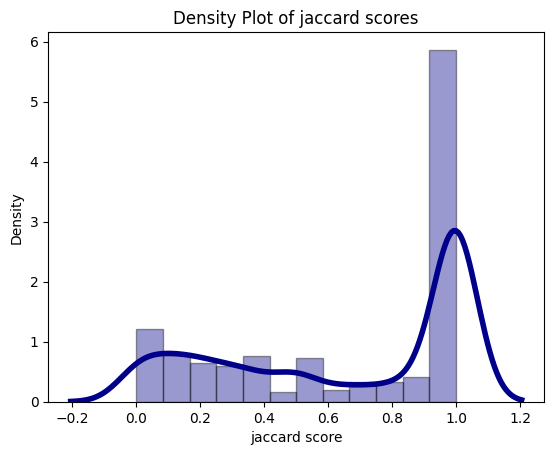

In [53]:
import seaborn as sns

sns.distplot(pred['jaccard score'], hist = True, kde = True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Density Plot of jaccard scores')
plt.xlabel('jaccard score')
plt.ylabel('Density')

In [54]:
ds =test["sentiment"]
ds = ds.reset_index(drop=True)  # Reset the index of the ds Series
pred["sentiment"] = ds

In [55]:
ds =test["text"]
ds = ds.reset_index(drop=True)  # Reset the index of the ds Series
pred["text"] = ds

In [56]:
pred

,Predicted,Ground Truth,jaccard score,sentiment,text
0,Enjoy !,Enjoy ! Family trumps everything,0.400000,positive,Enjoy ! Family trumps everything
1,,kinda turns me off,0.000000,negative,- - of them kinda turns me off of it all . ...
2,Clive it ' s my birthday pat me,Clive it ' s my birthday pat me,1.000000,neutral,Clive it ' s my birthday pat me
3,congrats,congrats,1.000000,positive,congrats hey
4,is texting,is texting,1.000000,neutral,is texting
...,...,...,...,...,...
5491,Just investigated whether I could change my us...,Just investigated whether I could change my us...,1.000000,neutral,Just investigated whether I could change my us...
5492,no one I know likes boiled peanuts t .,no one I know likes boiled peanuts t .,1.000000,neutral,no one I know likes boiled peanuts t .
5493,aww ) where ' d you get that ? hug...,aww ) where ' d you get that ? hugh is so t...,0.821429,neutral,aww ) where ' d you get that ? hugh is so t...
5494,so cold,so cold today ! !,0.500000,negative,Im craving some cinnamon toast crunch . Why i...


In [57]:
pred.sample(15)

,Predicted,Ground Truth,jaccard score,sentiment,text
1859,Good nite everybody !,Good,0.250000,positive,Good nite everybody !
691,Happy Mother ' s Day,Happy Mother ' s Day,1.000000,positive,Happy Mother ' s Day
1858,we miss you .,in _ love aww me too ! ! ! we miss you .,0.363636,positive,_ in _ love aww me too ! ! ! we miss you .
1101,look how choke on this * * * ...,look how choke on this * * * * talks to me,1.000000,neutral,look how choke on this * * * * talks to me
5009,i wanna join,i wanna join,1.000000,positive,i wanna join the twit Club . . . . . .
3634,i wanna move back to Pennsylvania,wanna move back to Pennsylvania,0.833333,neutral,i wanna move back to Pennsylvania
439,Getting ready for a long weekend of work . ...,Getting ready for a long weekend of work . . ...,1.000000,neutral,Getting ready for a long weekend of work . . ...
5094,"That may be , I still don ' t like he...",don ' t like,0.210526,negative,"That may be , I still don ' t like hearing hi..."
4362,Official whine - tweet for today . Not...,Official whine - tweet for today . Nothing sp...,1.000000,neutral,Official whine - tweet for today . Nothing sp...
1199,awwh - i ' m sorry i hope you fell be...,awwh - i ' m sorry i hope you fell better ...,1.000000,neutral,awwh - i ' m sorry i hope you fell better ...


/tmp/ipykernel_28/259465531.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset["jaccard score"], hist=False, kde=True,
/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_28/259465531.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) o

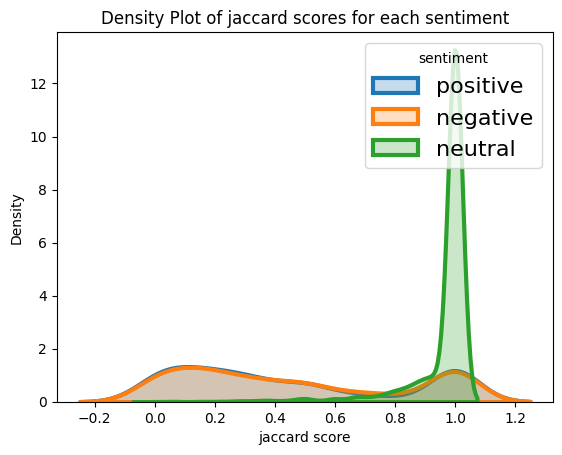

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiments = ['positive', 'negative', 'neutral']

for sentiment in sentiments:
    # Subset to the airline
    subset = pred[pred['sentiment'] == sentiment]
    
    # Draw the density plot
    sns.distplot(subset["jaccard score"], hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 3},
                 label=sentiment)

plt.legend(prop={'size': 16}, title='sentiment')
plt.title('Density Plot of jaccard scores for each sentiment')
plt.xlabel('jaccard score')
plt.ylabel('Density')

plt.show()

In [59]:
print('Mean jaccard score for all data:',TestScore )

Mean jaccard score for all data: 0.6585248805755792


In [60]:
pred[pred['jaccard score'] == 1]

,Predicted,Ground Truth,jaccard score,sentiment,text
2,Clive it ' s my birthday pat me,Clive it ' s my birthday pat me,1.0,neutral,Clive it ' s my birthday pat me
3,congrats,congrats,1.0,positive,congrats hey
4,is texting,is texting,1.0,neutral,is texting
5,Do you have any idea when the ( not so ...,Do you have any idea when the ( not so ) pat...,1.0,neutral,Do you have any idea when the ( not so ) pat...
6,Tell him where . . .,Tell him where . . .,1.0,neutral,Tell him where . . .
...,...,...,...,...,...
5488,Dfizzy if you ever read this Uh i got one ques...,Dfizzy if you ever read this Uh i got one ques...,1.0,neutral,Dfizzy if you ever read this Uh i got one ques...
5490,is giving me problems !,is giving me problems !,1.0,negative,FCKeditor is giving me problems ! Posts just ...
5491,Just investigated whether I could change my us...,Just investigated whether I could change my us...,1.0,neutral,Just investigated whether I could change my us...
5492,no one I know likes boiled peanuts t .,no one I know likes boiled peanuts t .,1.0,neutral,no one I know likes boiled peanuts t .


In [61]:
pred[pred['jaccard score'] == 0].sample(20)

,Predicted,Ground Truth,jaccard score,sentiment,text
5464,"my laptop broke ,",best,0.0,positive,"my laptop broke , who wants to help a girl ou..."
3979,couple,i ' ll have to wait . .,0.0,negative,in about half a hour i ' m going to my english...
4619,Thanks,Much love .,0.0,positive,"Thanks to all the new followers Well , I wen..."
771,i heard one of your songs,you have an amazing voice,0.0,positive,"i heard one of your songs , and you have an a..."
1629,enjoy,joy,0.0,positive,"why ? i enjoy fancy meals on my own smtimes ,..."
2818,problems,ne just doesn ' t want to work,0.0,negative,are you having any problems sending images fro...
2476,thanks,d help me a lot .,0.0,positive,cause my eyelids are not deep set . thanks i...
1087,so grateful for,happiest,0.0,positive,happiest girl in the world . best weekend ev...
3730,G ' day Than,Thanx,0.0,positive,G ' day Thanx for following .
1845,nasty flu !,thanks hopin,0.0,positive,and thanks hoping its just allergies and not...


In [62]:
print('Mean jaccard score for neutral data:',pred[pred.sentiment  =='neutral']['jaccard score'].mean())
print('Mean jaccard score for positive data:',pred[pred.sentiment =='positive']['jaccard score'].mean())
print('Mean jaccard score for negative data:',pred[pred.sentiment =='negative']['jaccard score'].mean())

Mean jaccard score for neutral data: 0.9596019503997912
Mean jaccard score for positive data: 0.4472964089819692
Mean jaccard score for negative data: 0.4567046220321226


In [63]:
######################################################################################